In [1]:
import json
from dataclasses import dataclass

from google.cloud import vision
from google.oauth2 import service_account
from google.oauth2.service_account import Credentials as Credentials

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import japanize_matplotlib
from PIL import Image
import numpy as np


In [2]:

@dataclass
class ConfigJSON:
    type: str
    project_id: str
    private_key_id: str
    private_key: str
    client_email: str
    client_id: str
    auth_uri: str
    token_uri: str
    auth_provider_x509_cert_url: str
    client_x509_cert_url: str
    universe_domain: str


def oauth(json_file_path: str) -> Credentials:
    return service_account.Credentials.from_service_account_file(json_file_path)


def get_image(img_path: str) -> bytes:
    with open(img_path, "rb") as file:
        return file.read()
    

def draw_texts(img_path: str, texts) -> None:
    # Open image file
    im = np.array(Image.open(img_path), dtype=np.uint8)

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    # Create a Rectangle patch and text for each detected text
    for text in texts[1:]: #texts[0] is the whole image
        vertices = [(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices]
        rect = patches.Polygon(vertices, linewidth=1, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
        ax.text(vertices[0][0], vertices[0][1], text.description, fontsize=7, color='blue')

    # Show the plot with detected texts
    plt.show()


def detect_text(img_path: str) -> None:

    credential = oauth("../baito-ocr-sample-ccb6bb9f060c.json")

    client = vision.ImageAnnotatorClient(credentials=credential)
    image = vision.Image(content=get_image(img_path))

    response = client.text_detection(image=image)

    texts = response.text_annotations
    print(type(texts))

    #結果を横に並べて表示
    for text in texts:
        print(text.description)
        print(text.bounding_poly)
    # <class 'proto.marshal.collections.repeated.RepeatedComposite'>
    draw_texts(img_path, texts)


    
    

if __name__ == "__main__":
    detect_text("../sheet1.jpg")


KeyboardInterrupt: 

In [6]:
#openCVによるチェックマークの認識テスト

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

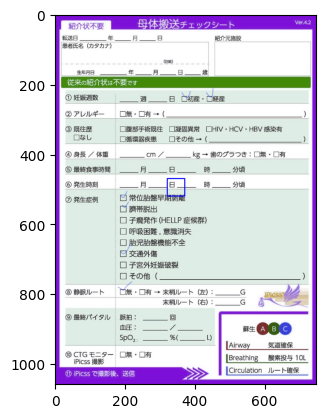

In [ ]:
#画像の読み込み
base_img = cv2.imread("../sheet1.jpg")
mark_img = cv2.imread("../checkmark.png")
#グレースケール化
base_gray = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
mark_gray = cv2.cvtColor(mark_img, cv2.COLOR_BGR2GRAY)
#マッチングテンプレート
result = cv2.matchTemplate(base_gray, mark_gray, cv2.TM_CCOEFF_NORMED)
#検出結果から検出領域の位置を取得
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
top_left = max_loc
bottom_right = (top_left[0] + 50, top_left[1] + 50)
#検出領域を四角で囲んでplot表示
result_img = cv2.imread("../sheet1.jpg")
cv2.rectangle(result_img, top_left, bottom_right, (0, 0, 255), 2)
plt.imshow(result_img)


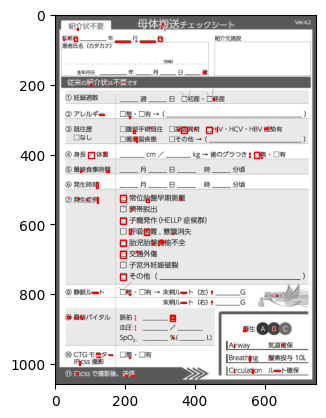

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def detect_checkboxes(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Perform binary thresholding on the image to make it black and white
    _, image_bin = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image
    contours, _ = cv2.findContours(image_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on their shape (rectangle) and size
    checkboxes = []
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour, True), True)
        x, y, w, h = cv2.boundingRect(approx)
        if len(approx) == 4 and w * h < 700:  # Change this value based on the size of the checkboxes
            checkboxes.append((x, y, w, h))

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image, cmap='gray')

    # Draw rectangles around the detected checkboxes
    for x, y, w, h in checkboxes:
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the plot with the detected checkboxes
    plt.show()

# Call the function with your image path
detect_checkboxes('../sheet1.jpg')


In [4]:
from boxdetect.pipelines import get_checkboxes, get_boxes
from boxdetect import config

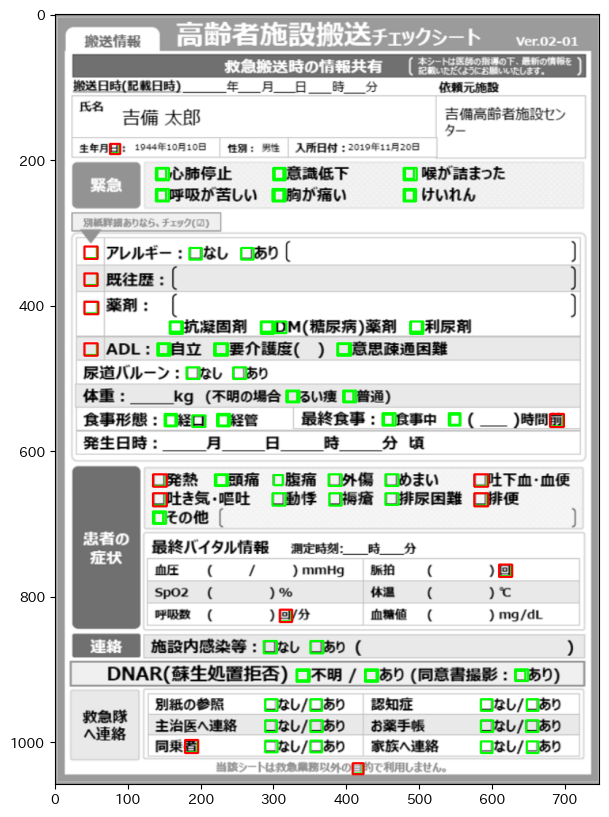

In [23]:
file_path: str = "../sheet4.png"

cfg = config.PipelinesConfig()
# チェックボックスの大きさに合わせて幅と高さの範囲を設定
# ここでは、チェックボックスが正方形であると仮定して、幅と高さの範囲を同じに設定します
cfg.width_range = (12, 50)  # チェックボックスの幅が20から50ピクセルの範囲にあると仮定
cfg.height_range = (13, 17)  # チェックボックスの高さが20から50ピクセルの範囲にあると仮定

# スケーリング因子を設定
cfg.scaling_factors = [1.0, 1.3, 10]  # 複数のスケーリング因子を使用して精度を向上

# ボックスの幅と高さの比率の範囲を設定
# 正方形のチェックボックスを検出するため、幅と高さの比率は1に近い値になるはずです
cfg.wh_ratio_range = (0.9, 1.1)  # 幅と高さの比率が0.9から1.1の範囲にあるボックスを検出

# ボックスのグループサイズの範囲を設定
# チェックボックスは通常単独で存在するため、グループサイズの範囲を(1, 1)に設定
cfg.group_size_range = (1, 1)

# ダイレーション変換の反復回数を設定
cfg.dilation_iterations = 0  # 画像を強調表示するためにダイレーション変換を1回実行

# Load the image
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (748, 1058))
rects, grouping_rects, image, output_image = get_boxes(img, cfg=cfg, plot=False)
#緑が検出されたチェックボックスの単位
#赤がグループ化されたチェックボックスの単位
#get_checkboxes()
plt.figure(figsize=(10,10))
plt.imshow(output_image)
plt.show()
